In [81]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sentence_transformers import SentenceTransformer
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [82]:
class HateSpeechRFClassifier:
    def __init__(self, threshold: float = 0.75, n_estimators: int = 100, max_depth: int = None, class_weight=None):
        self.threshold = threshold
        self.encoder = SentenceTransformer("all-MiniLM-L6-v2")
        self.model = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            class_weight=class_weight,
            random_state=42
        )

    def embed(self, texts: pd.Series) -> np.ndarray:
        return self.encoder.encode(texts.tolist(), show_progress_bar=False)

    def train(self, X: pd.Series, y: pd.Series) -> None:
        X_embed = self.embed(X)
        self.model.fit(X_embed, y)

    def predict_proba(self, X: pd.Series) -> pd.Series:
        X_embed = self.embed(X)
        proba = self.model.predict_proba(X_embed)[:, 1]
        return pd.Series(proba, index=X.index)

    def predict(self, X: pd.Series) -> pd.Series:
        proba = self.predict_proba(X)
        return (proba > self.threshold).astype(int)

    def evaluate(self, X_test: pd.Series, y_test: pd.Series) -> None:
        y_pred = self.predict(X_test)
        print(classification_report(y_test, y_pred))

    def plot_confusion_matrix(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Hate", "Hate"], yticklabels=["Not Hate", "Hate"])
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

    def show_misclassifications(self, X: pd.Series, y_true: pd.Series, y_pred: pd.Series):
        mismatches = X[(y_true != y_pred)]
        print("\nFALSE POSITIVES:")
        print(mismatches[(y_true == 0) & (y_pred == 1)].head(5).to_string(index=False))

        print("\nFALSE NEGATIVES:")
        print(mismatches[(y_true == 1) & (y_pred == 0)].head(5).to_string(index=False))


In [123]:
def main():
    train_df = pd.read_csv("../data/train_data.csv")
    test_df = pd.read_csv("../data/test_data_clean.csv")

    X_train = train_df["text"]
    y_train = train_df["label"].astype(int)

    test_df = test_df.rename(columns={"comment": "text", "isHate": "label"})
    X_test = test_df["text"]
    y_test = test_df["label"].astype(int)

    model = HateSpeechRFClassifier(threshold=0.5, class_weight="balanced")
    model.train(X_train, y_train)
    model.evaluate(X_test, y_test)

    test_probs = model.predict_proba(X_test)
    test_preds = model.predict(X_test)

    model.plot_confusion_matrix(y_test, test_preds)
    model.show_misclassifications(X_test, y_test, test_preds)

    test_df_out = pd.DataFrame({
        "text": X_test,
        "true_label": y_test,
        "probability": test_probs,
        "prediction": test_preds
    })
    test_df_out.to_csv("../data/hate_speech_test_predictions_rf.csv", index=False)

    misclassified = test_df_out[test_df_out["true_label"] != test_df_out["prediction"]]
    misclassified.to_csv("../data/misclassified_test_examples.csv", index=False)

    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, f1_score

    fpr, tpr, _ = roc_curve(y_test, test_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve - Test Data")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    precision, recall, thresholds = precision_recall_curve(y_test, test_probs)
    avg_prec = average_precision_score(y_test, test_probs)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f"PR curve (AP = {avg_prec:.2f})", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve - Test Data")
    plt.legend(loc="lower left")
    plt.grid(True)
    plt.show()

    best_f1 = 0
    best_thresh = 0
    for thresh in thresholds:
        preds = (test_probs > thresh).astype(int)
        score = f1_score(y_test, preds)
        if score > best_f1:
            best_f1 = score
            best_thresh = thresh

    print(f"Best threshold by F1: {best_thresh:.3f} → F1 = {best_f1:.3f}")

    return model, X_test, y_test

#fun little comment





              precision    recall  f1-score   support

           0       0.68      0.70      0.69       475
           1       0.72      0.70      0.71       523

    accuracy                           0.70       998
   macro avg       0.70      0.70      0.70       998
weighted avg       0.70      0.70      0.70       998



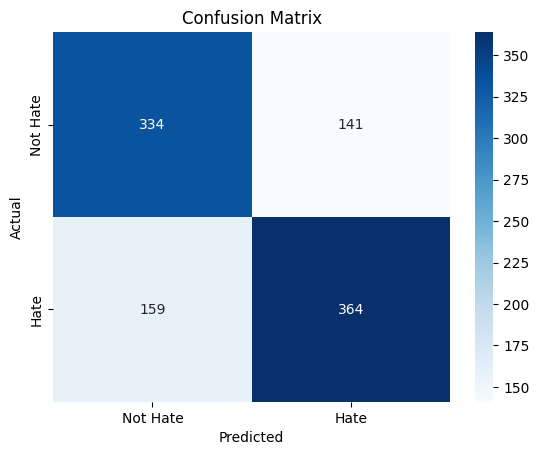


FALSE POSITIVES:
I don't see why we don't just create a transgen...
You guys I fell so bad, I hope this don’t happe...
Well this is like exactly how I feel. Except I ...
               We are proud to be an Indian Muslim
To the lady that can barely speak English and t...

FALSE NEGATIVES:
Why don’t you go beck your god to murder you? C...
why does that african american monkey hold gun ...
Who do you think you are cunt? wtf! Stay steady...
Watching this kid trying to step up and walk wi...
                        U SUCK SHIT YOU BLACK FUCK


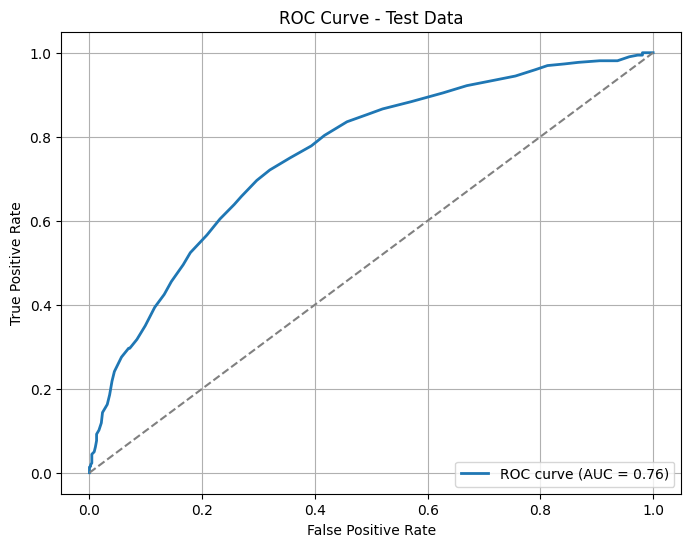

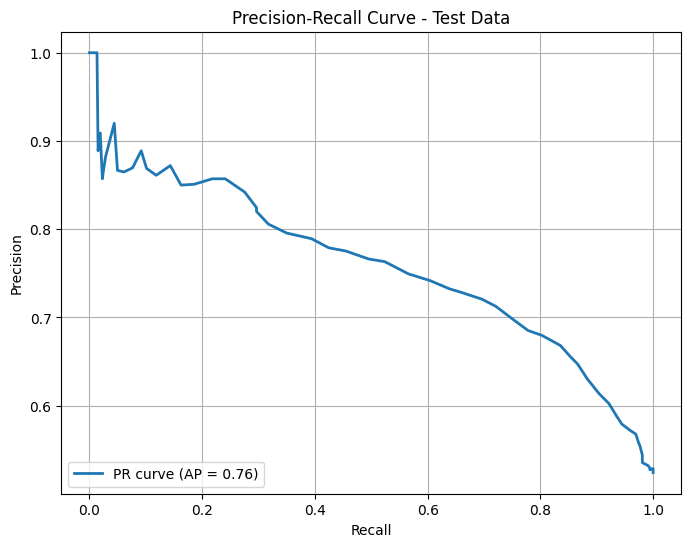

Best threshold by F1: 0.450 → F1 = 0.743


(<__main__.HateSpeechRFClassifier at 0x3b5a6ca30>,
 0              You should know women's sports are a joke
 1        You look like Sloth with deeper Down’s syndrome
 2      You look like Russian and speak like Indian. B...
 3                   Women deserve to be abused, I guess.
 4      Women are made for making babies and cooking d...
                              ...                        
 993     From the midnight sun where the hot springs blow
 994                          Don't say I'm not your type
 995     And therefore never send to know for whom the...
 996                        And I can't stand another day
 997     All values, unless otherwise stated, are in U...
 Name: text, Length: 998, dtype: object,
 0      1
 1      1
 2      1
 3      1
 4      1
       ..
 993    0
 994    0
 995    0
 996    0
 997    0
 Name: label, Length: 998, dtype: int64)

In [124]:
main()

In [118]:
import pandas as pd
test_df = pd.read_csv("../data/test_data_clean.csv")
print(test_df.columns.tolist())


['comment', 'isHate']
